In [1]:
import random

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math

import time
import sys
from collections import OrderedDict
from collections import defaultdict

In [2]:
def generate_locality_access_pattern(alphabet_size, total_requests, window_size=10, switch_prob=0.05):
    full_alphabet = [chr(ord('A') + i) for i in range(alphabet_size)]
    current_window = random.sample(full_alphabet, min(window_size, alphabet_size))
    accesses = []

    for _ in range(total_requests):
        if random.random() < switch_prob:
            current_window = random.sample(full_alphabet, min(window_size, alphabet_size))
        accesses.append(random.choice(current_window))
    
    return accesses

In [3]:
class LRUCache:
    def __init__(self, capacity):
        self.capacity = capacity
        self.cache = OrderedDict()
        self.page_faults = 0
        self.total_time = 0.0

    def access(self, key):
        start = time.perf_counter()

        if key in self.cache:
            self.cache.move_to_end(key) # end tracks most recently used
        else:
            self.page_faults += 1
            if len(self.cache) >= self.capacity:
                self.cache.popitem(last=False) # beginning tracks LRU
            self.cache[key] = key # read-through cache

        self.total_time += time.perf_counter() - start
        return self.cache[key]

    def get_stats(self, total_requests):
        hit_rate = 1 - self.page_faults / total_requests
        return {
            "runtime": self.total_time * 1000,
            "page_faults": self.page_faults,
            "hit_rate": hit_rate
        }

In [4]:
class LFUCache:
    def __init__(self, capacity):
        self.capacity = capacity
        self.cache = {}
        self.freq = defaultdict(set)
        self.key_freq = {}
        self.min_freq = 0
        self.page_faults = 0
        self.total_time = 0.0

    def update_freq(self, key):
        f = self.key_freq[key]
        self.freq[f].remove(key)
        if not self.freq[f]:
            del self.freq[f]
            if self.min_freq == f:
                self.min_freq += 1

        self.key_freq[key] += 1
        self.freq[self.key_freq[key]].add(key)

    def access(self, key):
        start = time.perf_counter()

        if key in self.cache:
            self.update_freq(key)
        else:
            self.page_faults += 1
            if len(self.cache) >= self.capacity:
                evict_key = next(iter(self.freq[self.min_freq]))
                self.freq[self.min_freq].remove(evict_key)
                del self.cache[evict_key]
                del self.key_freq[evict_key]

            self.cache[key] = key
            self.key_freq[key] = 1
            self.freq[1].add(key)
            self.min_freq = 1

        self.total_time += time.perf_counter() - start
        return self.cache[key]

    def get_stats(self, total_requests):
        hit_rate = 1 - self.page_faults / total_requests
        return {
            "runtime": self.total_time * 1000,
            "page_faults": self.page_faults,
            "hit_rate": hit_rate,
        }

In [5]:
def run_experiments(cache_classes, cache_sizes, alphabet_sizes, total_requests=10000, seed=42):
    results = []

    random.seed(seed)

    for alphabet_size in alphabet_sizes:
        for cache_size in cache_sizes:
            accesses = generate_locality_access_pattern(
                alphabet_size=alphabet_size,
                total_requests=total_requests,
                window_size=math.floor(alphabet_size*0.1),
                switch_prob=0.1
            )

            for cache_name, cache_cls in cache_classes.items():
                cache = cache_cls(capacity=cache_size)

                for key in accesses:
                    cache.access(key)

                ratio = cache_size / alphabet_size
                if ratio > 1:
                    ratio = None

                stats = cache.get_stats(total_requests=total_requests)
                results.append({
                    "cache_type": cache_name,
                    "alphabet_size": alphabet_size,
                    "cache_size": cache_size,
                    "cache_ratio": ratio,
                    "runtime_ms": stats["runtime"],
                    "page_faults": stats["page_faults"],
                    "hit_rate": stats["hit_rate"]
                })

    return pd.DataFrame(results)

In [6]:
cache_classes = {
    "LRU": LRUCache,
    "LFU": LFUCache
}

In [7]:
cache_sizes = [10, 25, 50, 100, 200, 400]
alphabet_sizes = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
plot_colors = len(alphabet_sizes)

df_results = run_experiments(
    cache_classes=cache_classes,
    cache_sizes=cache_sizes,
    alphabet_sizes=alphabet_sizes
)

In [8]:
df_results

,cache_type,alphabet_size,cache_size,cache_ratio,runtime_ms,page_faults,hit_rate
0,LRU,10,10,1.00,0.878326,10,0.9990
1,LFU,10,10,1.00,4.135838,10,0.9990
2,LRU,10,25,NaN,0.875882,10,0.9990
3,LFU,10,25,NaN,4.236131,10,0.9990
4,LRU,10,50,NaN,0.879001,10,0.9990
...,...,...,...,...,...,...,...
103,LFU,5000,100,0.02,4.434629,9768,0.0232
104,LRU,5000,200,0.04,2.601441,9453,0.0547
105,LFU,5000,200,0.04,5.237337,9597,0.0403
106,LRU,5000,400,0.08,2.646834,9046,0.0954


In [9]:
def plot_runtime_vs_size(df=df_results):
    cache_types = df["cache_type"].unique()
    bold_palette = sns.color_palette("tab10", n_colors=plot_colors)  # match this to alphabet sizes

    for cache_type in cache_types:
        plt.figure(figsize=(8, 5))
        subset = df[df["cache_type"] == cache_type]

        sns.lineplot(
            data=subset,
            x="cache_size",
            y="runtime_ms",
            hue="alphabet_size",
            palette=bold_palette,
            markers=True,
            style="alphabet_size",
            dashes=False,
            linewidth=2,
            markeredgewidth=1.5
        )

        plt.title(f"Runtime vs Cache Size ({cache_type})")
        plt.xlabel("Cache Size (k)")
        plt.ylabel("Runtime (ms)")
        plt.legend(title="Alphabet Size")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"Runtime_vs_Cache_Size_{cache_type}.png")

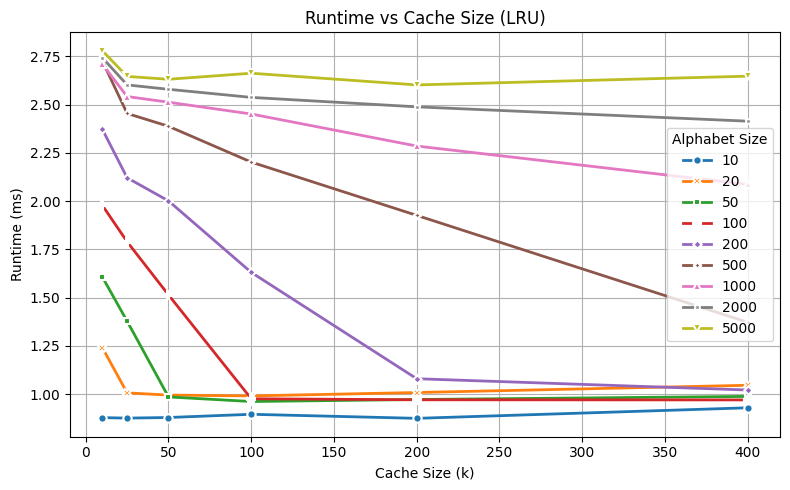

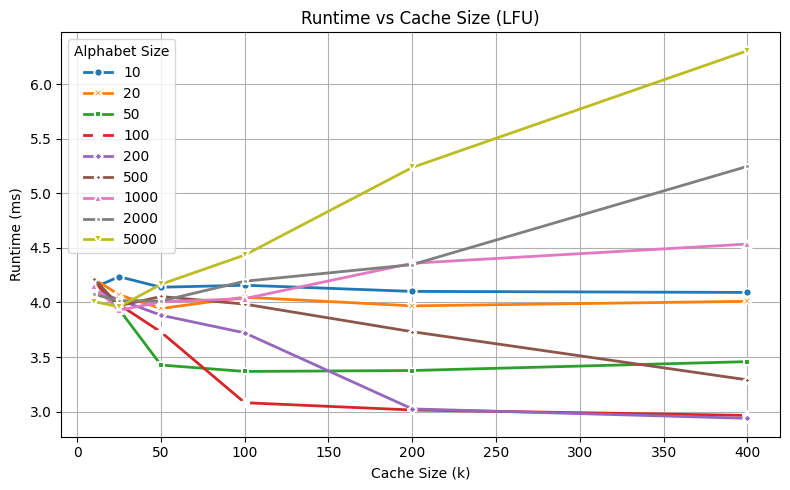

In [10]:
plot_runtime_vs_size()

In [17]:
def plot_hit_rate_vs_ratio(df=df_results):
    cache_types = df["cache_type"].unique()
    bold_palette = sns.color_palette("tab10", n_colors=plot_colors)

    for cache_type in cache_types:
        plt.figure(figsize=(8, 5))
        subset = df[df["cache_type"] == cache_type]
        subset = subset[subset["cache_ratio"].notna()]
        sns.lineplot(
            data=subset,
            x="cache_ratio",
            y="hit_rate",
            hue="alphabet_size",
            palette=bold_palette,
            markers=True,
            style="alphabet_size",
            dashes=False,
            linewidth=2,
            markeredgewidth=1.5
        )

        plt.title(f"Hit Rate vs Cache Ratio ({cache_type})")
        plt.xlabel("Cache Ratio (cache_size / alph_size)")
        plt.ylabel("Hit Rate")
        plt.legend(title="Alphabet Size")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"Hit_Rate_vs_Cache_Ratio_{cache_type}.png")

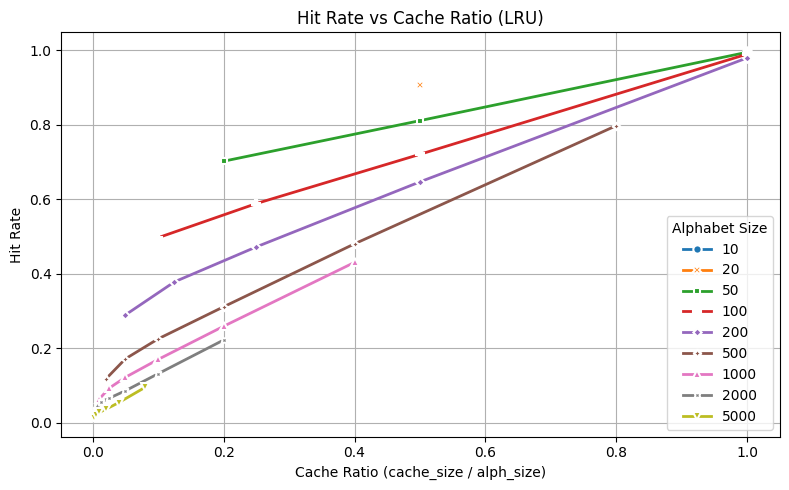

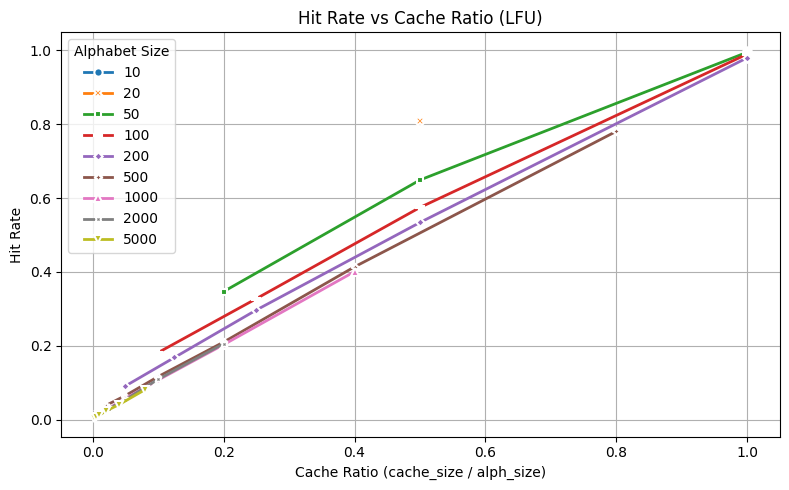

In [18]:
plot_hit_rate_vs_ratio()

In [13]:
def plot_hit_rate_vs_size(df=df_results):
    cache_types = df["cache_type"].unique()
    bold_palette = sns.color_palette("tab10", n_colors=plot_colors)

    for cache_type in cache_types:
        plt.figure(figsize=(8, 5))
        subset = df[df["cache_type"] == cache_type]

        sns.lineplot(
            data=subset,
            x="cache_size",
            y="hit_rate",
            hue="alphabet_size",
            palette=bold_palette,
            markers=True,
            style="alphabet_size",
            dashes=False,
            linewidth=2,
            markeredgewidth=1.5
        )

        plt.title(f"Hit Rate vs Cache Size ({cache_type})")
        plt.xlabel("Cache Size")
        plt.ylabel("Hit Rate")
        plt.legend(title="Alphabet Size")
        plt.grid(True, which="both", linestyle="--", linewidth=0.5)
        plt.tight_layout()
        plt.savefig(f"Hit_Rate_vs_Cache_Size_{cache_type}.png")

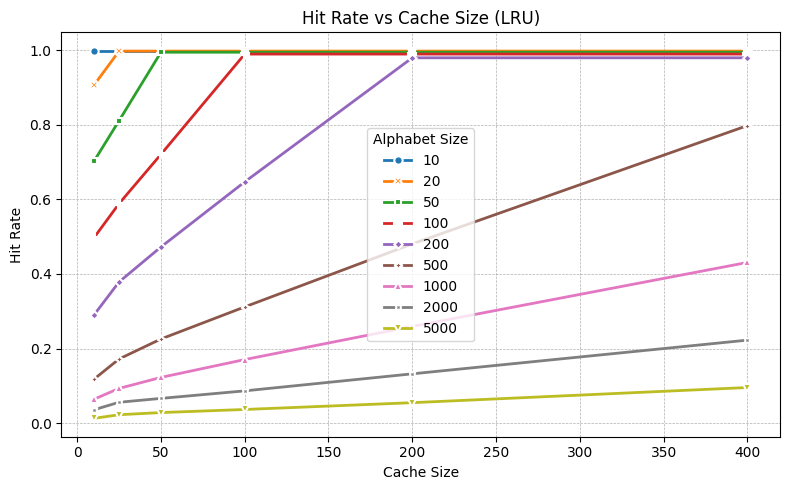

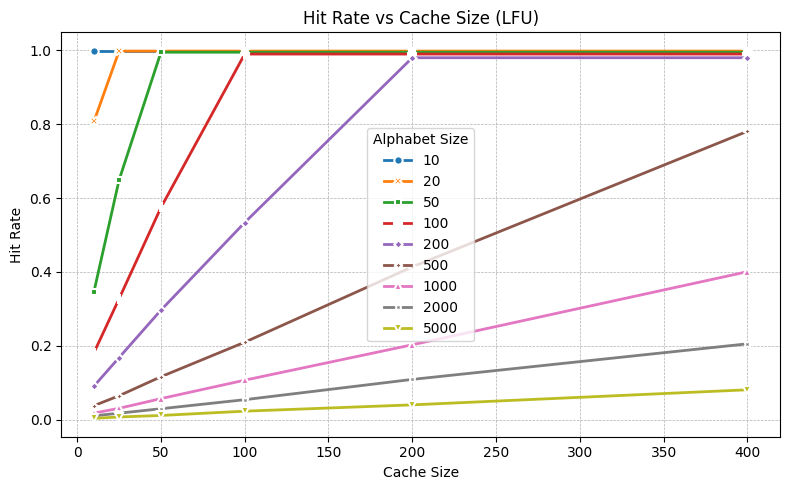

In [14]:
plot_hit_rate_vs_size()

In [15]:
def plot_empirical_vs_theoretical(df=df_results):
    df = df.copy()
    df["theoretical_hit_rate"] = df["cache_size"] / df["alphabet_size"]
    cache_types = df["cache_type"].unique()

    for cache_type in cache_types:
        plt.figure(figsize=(8, 6))
        subset = df[df["cache_type"] == cache_type]

        # Scatter plot with heatmap color indicating alphabet size
        scatter = plt.scatter(
            subset["theoretical_hit_rate"],
            subset["hit_rate"],
            c=subset["alphabet_size"],
            cmap="viridis",
            s=80,
            edgecolors='k',
            alpha=0.9
        )

        # y = x reference line
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1.5, label="Perfect Prediction")

        cbar = plt.colorbar(scatter)
        cbar.set_label("Alphabet Size")

        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.title(f"Empirical vs Theoretical Hit Rate ({cache_type})")
        plt.xlabel("Theoretical Hit Rate")
        plt.ylabel("Empirical Hit Rate")
        plt.grid(True, linestyle="--", linewidth=0.5)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"Empirical_vs_Theoretical_Hit_Rate_{cache_type}.png")

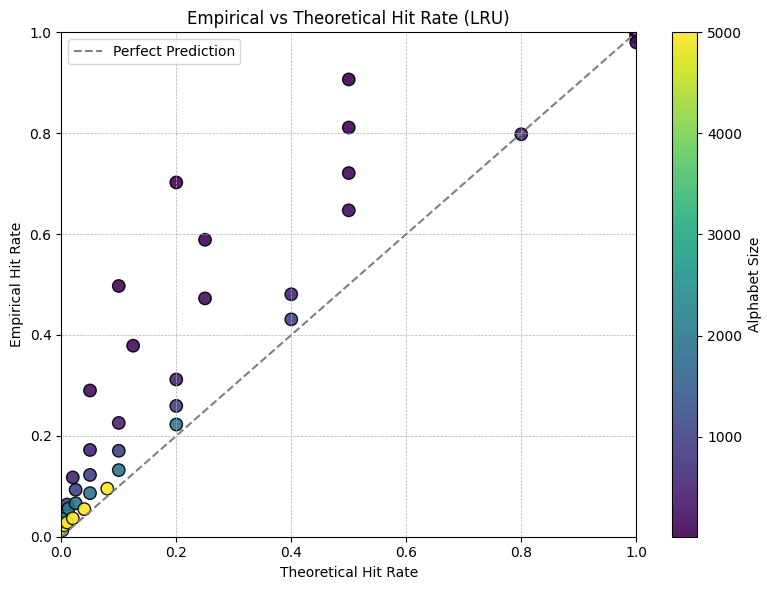

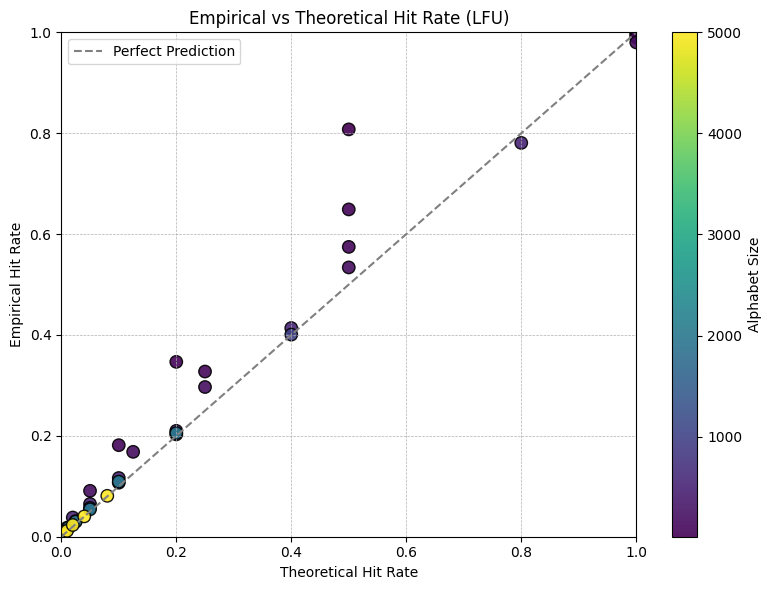

In [16]:
plot_empirical_vs_theoretical()